<a href="https://colab.research.google.com/github/FlashChoi5657/ECG_cls/blob/main/ECG_classification(kaggle).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heartbeat:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F29414%2F37484%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240830%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240830T080355Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db7b9dfae091387a2015fc3be7f33e04443084f58ab33d1080f2b1da10ac668de72adfad345c571f7096beeb73bd76389d26b7bda26a8e14a724a40237be404348441109cc8eca2ca83939962ee8c84161a435213f8fab0fda5308b7779c91786a48b35e2a5d96597485a6a43cc9b3cb983924e2c3b1d3e7e1ae7b91ae1e6c716fc5de7a69b7bc2668045ac14ebea7aa332e31a4d75db67440ec1e5ed2cc2aeaede52e6b10cca9c00e215d838af8a38e8399d15d8469bb524ce854a4a9ec5cd9b275d7a052aebba9cb3ba2e48fd306fc3537914feb9951bb3952e7c441fb58c6e331d504f9d56a362a264a6a0df4f972f6fd8832db1e833a750ae77fa7b2ea7b9,mit-bih-arrhythmia-database-modern-2023:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3504103%2F6114424%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240830%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240830T080355Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6b9aab349a7bb956ba11a3e84b791b0bb2dc5f4894215e8dd1cad84325b99c7ac81a10822327e8aa896301acb1a5528f93377c3a4a5b21f52d95f87b561276a5e57a1f78f4db60bb22d176b31cb5a23bf1a8fcc1b6481e1eaa3a3b3b55f516efbdd9eda833cf74f18f55d46655ad0dd4dce9c2a0970138770208cb394e5fdebd2a7179d996f5746d30fdaba8686a172fb71d2a4224751ebe2738168528b1a5382039c2e85fe221c88d1b33248c9ce42255eb677e734287127a5c0eb443ead356f2aad8c57b6c3ef45270e82595f98ea5b961ebe5610a1dc9fb36c01ef2de74487d225f1c7ed54c0c344d6dbd89d8b581e352a6e2a18d3b419d47ef52d3da5eb9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this notebook,  ECG signal visualization, and classification of five categories "Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]" with using the popular database MIT-BIH Arrhythmia Database.

In [2]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting and visualization
import matplotlib.image as mpimg  # For reading images
import numpy as np  # For numerical operations
import scipy  # For scientific computations
import itertools  # For advanced iteration
from datetime import datetime  # For handling date and time

**Visualization**
In this part, the electrocardiogram (ECG/EKG) signal for one patient will be visualized
Visualization steps and operations subject to DSP courseon the EKG signal

In [3]:
# Load the ECG data from a CSV file into a DataFrame
ecg100 = pd.read_csv("/content/drive/MyDrive/ekg_dataset/100.csv")

# Display the first few rows of the DataFrame to understand its structure
ecg100

,Unnamed: 0,time_ms,MLII,V5
0,0,0.000000e+00,-0.145,-0.065
1,1,2.777778e+00,-0.145,-0.065
2,2,5.555556e+00,-0.145,-0.065
3,3,8.333333e+00,-0.145,-0.065
4,4,1.111111e+01,-0.145,-0.065
...,...,...,...,...
649995,649995,1.805542e+06,-0.075,-0.480
649996,649996,1.805544e+06,-0.445,-0.410
649997,649997,1.805547e+06,-0.675,-0.365
649998,649998,1.805550e+06,-0.765,-0.335


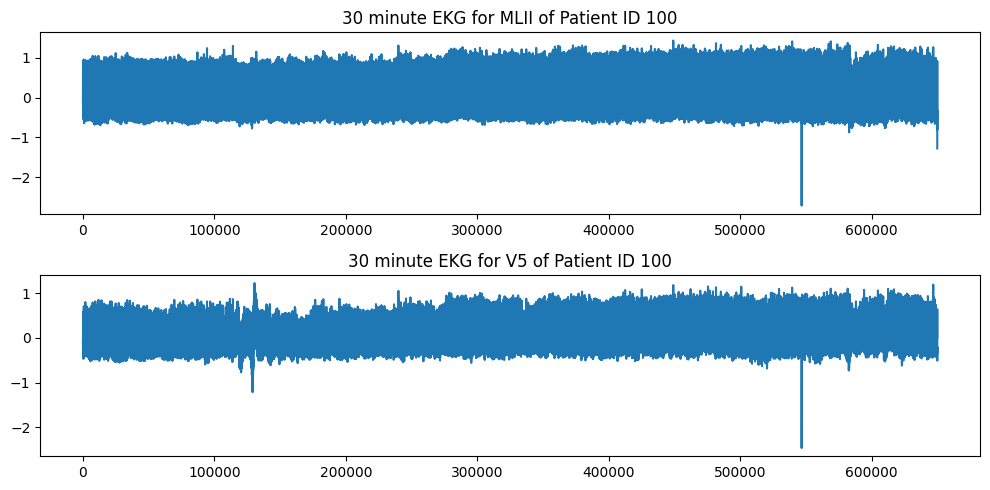

In [4]:
# Create a figure with a specified size for the plots
plt.figure(figsize=(10, 5))

# Create the first subplot in a 2-row, 1-column layout
plt.subplot(2, 1, 1)
# Plot the "MLII" column from the DataFrame to visualize the ECG signal for lead MLII
plt.plot(ecg100["MLII"])
# Set the title for the first subplot
plt.title("30 minute EKG for MLII of Patient ID 100")

# Create the second subplot in the same 2-row, 1-column layout
plt.subplot(2, 1, 2)
# Plot the "V5" column from the DataFrame to visualize the ECG signal for lead V5
plt.plot(ecg100["V5"])
# Set the title for the second subplot
plt.title("30 minute EKG for V5 of Patient ID 100")

# Adjust the layout to ensure that subplots do not overlap
plt.tight_layout()

In [5]:
# Print descriptive statistics for the "MLII" column
# This includes count, mean, standard deviation, min, 25th percentile, median (50th percentile), 75th percentile, and max
print(ecg100["MLII"].describe(), "\n")

# Print descriptive statistics for the "V5" column
print(ecg100["V5"].describe())

count    650000.000000
mean         -0.306299
std           0.193200
min          -2.715000
25%          -0.390000
50%          -0.335000
75%          -0.270000
max           1.435000
Name: MLII, dtype: float64 

count    650000.000000
mean         -0.191034
std           0.148213
min          -2.465000
25%          -0.265000
50%          -0.205000
75%          -0.145000
max           1.225000
Name: V5, dtype: float64


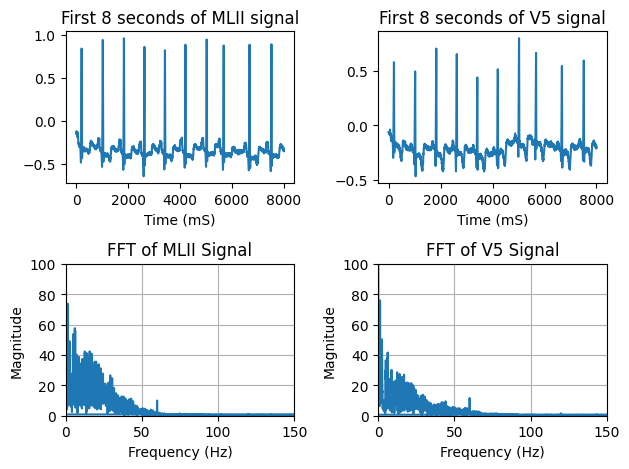

In [6]:
time = 8  # 8 seconds of data
fs = 360 # Sampling frequency (Hz)

MLII_data = ecg100[0: time*fs]["MLII"].values
MLIIF = scipy.fft.fft(MLII_data)

V5_data = ecg100[0: time*fs]["V5"].values
V5F = scipy.fft.fft(V5_data)

t = ecg100[0: time*fs]["time_ms"].values
frequencies = np.fft.fftfreq(len(V5_data), 1/fs)

plt.subplot(2, 2, 1)
plt.plot(t, MLII_data)
plt.title("First 8 seconds of MLII signal")
plt.xlabel('Time (mS)')

plt.subplot(2, 2, 2)
plt.plot(t, V5_data)
plt.title("First 8 seconds of V5 signal")
plt.xlabel('Time (mS)')

plt.subplot(2, 2, 3)
plt.plot(frequencies, np.abs(MLIIF))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of MLII Signal')
# Set axis limits
plt.ylim(0, 100)
plt.xlim(0, 150)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(frequencies, np.abs(V5F))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of V5 Signal')
# Set axis limits
plt.ylim(0, 100)
plt.xlim(0, 150)
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

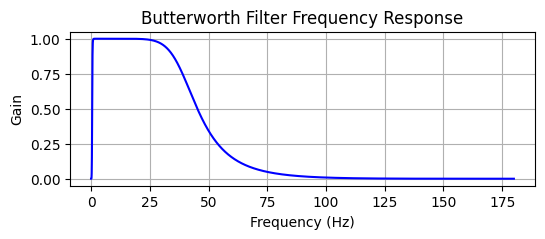

In [7]:
# Define bandpass filter parameters
lowcut = 0.5  # Low cutoff frequency (Hz)
highcut = 40  # High cutoff frequency (Hz)
order = 4    # Filter order

# Design the bandpass filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = scipy.signal.butter(order, [low, high], btype='band')

# Plot the frequency response of the filter
w, h = scipy.signal.freqz(b, a, worN=8000)
frequencies = (fs * 0.5 / np.pi) * w
plt.figure(figsize=(6, 2))
plt.plot(frequencies, abs(h), 'b')
plt.title('Butterworth Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.show()

Apply filters to the ECG signals

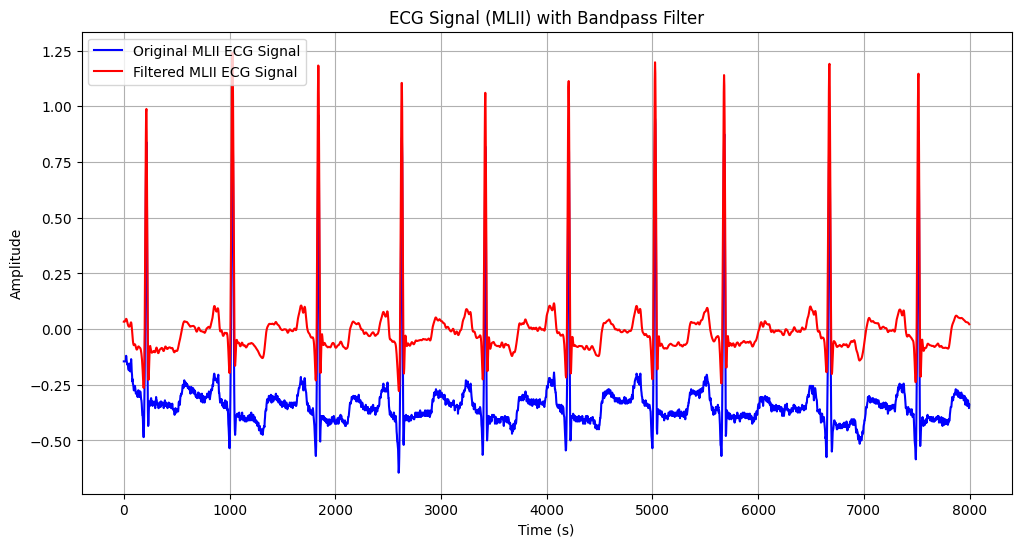

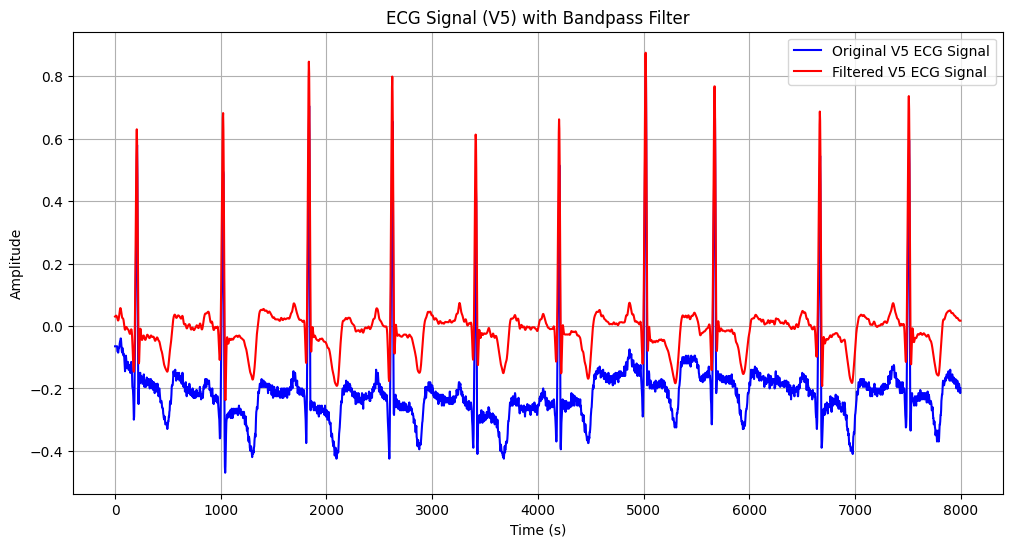

In [8]:
filtered_MLII_signal = scipy.signal.filtfilt(b, a, MLII_data)
# Plot original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(t, MLII_data, 'b', label='Original MLII ECG Signal')
plt.plot(t, filtered_MLII_signal, 'r', label='Filtered MLII ECG Signal')
plt.title('ECG Signal (MLII) with Bandpass Filter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

filtered_V5_signal = scipy.signal.filtfilt(b, a, V5_data)
# Plot original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(t, V5_data, 'b', label='Original V5 ECG Signal')
plt.plot(t, filtered_V5_signal, 'r', label='Filtered V5 ECG Signal')
plt.title('ECG Signal (V5) with Bandpass Filter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

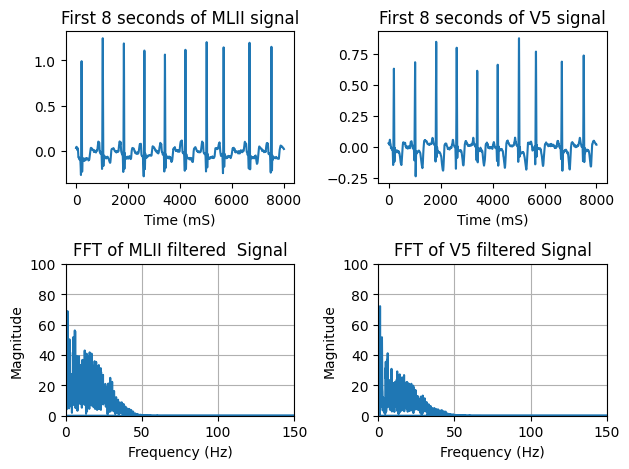

In [9]:
MLIIFF = scipy.fft.fft(filtered_MLII_signal)
V5FF = scipy.fft.fft(filtered_V5_signal)
frequencies = np.fft.fftfreq(len(filtered_V5_signal), 1/fs)

plt.subplot(2, 2, 1)
plt.plot(t, filtered_MLII_signal)
plt.title("First 8 seconds of MLII signal")
plt.xlabel('Time (mS)')

plt.subplot(2, 2, 2)
plt.plot(t, filtered_V5_signal)
plt.title("First 8 seconds of V5 signal")
plt.xlabel('Time (mS)')

plt.subplot(2, 2, 3)
plt.plot(frequencies, np.abs(MLIIFF))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of MLII filtered  Signal')
# Set axis limits
plt.ylim(0, 100)
plt.xlim(0, 150)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(frequencies, np.abs(V5FF))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of V5 filtered Signal')
# Set axis limits
plt.ylim(0, 100)
plt.xlim(0, 150)
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

**ECG Diagnosis Using 1D CNN**

In [ ]:
train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)

X_train, y_train = train.iloc[:, :187], train[187]
X_test, y_test = test.iloc[:, :187], test[187]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and testing data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the model
class ECGNet(nn.Module):
    def __init__(self, num_classes):
        super(ECGNet, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=80, stride=4, padding=38)
        self.bn1 = nn.BatchNorm1d(128)
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # Adjusted kernel size and stride
        # Layer 2
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.maxpool2 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # Adjusted kernel size and stride
        # Layer 3
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.maxpool3 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # Adjusted kernel size and stride
        # Layer 4
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.maxpool4 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # Adjusted kernel size and stride
        # Output layer
        self.avgpool = nn.AdaptiveAvgPool1d(1)  # AdaptiveAvgPool1d to handle variable input lengths
        self.fc = nn.Linear(512, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Layer 1
        x = self.maxpool1(self.bn1(torch.relu(self.conv1(x))))
        # Layer 2
        x = self.maxpool2(self.bn2(torch.relu(self.conv2(x))))
        # Layer 3
        x = self.maxpool3(self.bn3(torch.relu(self.conv3(x))))
        # Layer 4
        x = self.maxpool4(self.bn4(torch.relu(self.conv4(x))))
        # Output layer
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.log_softmax(x)
        return x

# Instantiate the model
num_classes = 5  # Change to the actual number of classes in your dataset
model = ECGNet(num_classes)
# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training the model
num_epochs = 10
start_time = datetime.now()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
end_time = datetime.now()
print("\nTotal training time: {}".format(end_time - start_time))

# Evaluation on test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
